# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [79]:
import twitter

CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN_KEY = ""
ACCESS_TOKEN_SECRET = ""

api = twitter.Api(consumer_key = CONSUMER_KEY, 
                  consumer_secret = CONSUMER_SECRET, 
                  access_token_key = ACCESS_TOKEN_KEY, 
                  access_token_secret = ACCESS_TOKEN_SECRET,
                  sleep_on_rate_limit=True)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [80]:
def form(x):
    fields = {u"text", u"id", u'user', u'lang', u'created_at'}
    format_x = {i: x[i] for i in fields}
    return format_x
def get_user_tweets(user_id):
    try:
        tweets = api.GetUserTimeline(user_id, count = 200, trim_user=True)
        tweets = map(lambda x: x.AsDict(), tweets)
        tweets = filter(lambda x: (u"retweeted_status" not in x) and (u"text" in x) and (x[u"lang"] == u"en"), tweets)
        tweets = map(form, tweets)
    except:
        tweets = None
    return tweets

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [81]:
from nltk.tokenize import RegexpTokenizer
def get_words(text):
    tokenizer = RegexpTokenizer("\w[^!.;,?\s]*\w|\w")
    s = []
    s = tokenizer.tokenize(text)
    answer = []
    for i in s:
        if (not ((i.find('http') != -1) or (i == 'RT') or (i.find('\\') != -1) or (i.find('/') != -1))):
            answer.append(i)
    return answer

In [82]:
print get_words("Here are different words!")

['Here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [83]:
import nltk
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [84]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def get_tokens(words):
    stop_words = stopwords.words("english")
    lemma = WordNetLemmatizer()
    tokens = []
    for i in words:
        if (i not in stop_words):
            tokens.append(lemma.lemmatize(i.lower()))
    return tokens

In [85]:
print get_tokens(["here", "are", "different", "words", "words"])

['different', u'word', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [86]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet))

print get_tweet_tokens("Convention 2017 Khepri will be available in the SWC 2017 Digital Lootpack &amp; at various conventions throughout the y\u2026 https://t.co/EYtYUUeoQm")

['convention', '2017', 'khepri', 'available', 'swc', '2017', 'digital', 'lootpack', 'amp', 'various', u'convention', 'throughout']


Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [87]:
def collect_users_tokens(df_users):
    df_users = df_users['uid'].tolist()
    all_users_tokens = []
    all_users = []
    for uid in df_users:
        if not (uid in processed_users): 
            all_users.append(uid)
            one_user_tokens = {}
            one_tweets = get_user_tweets(uid)
            if one_tweets is None:
                one_user_tokens = {None : None}
            else:
                user_tokens = []
                for tweet in one_tweets:
                    user_tokens = user_tokens + get_tweet_tokens(tweet[u'text'])
                for token in user_tokens:
                    count = one_user_tokens.setdefault(token)
                    if (count is None):
                        one_user_tokens.update({token : 1})
                    else:
                        one_user_tokens.update({token : count + 1})
            f.write(json.dumps([uid, one_user_tokens]) + '\n')
            all_users_tokens.append(one_user_tokens)
    return all_users, all_users_tokens


In [88]:
import pandas as pd
from collections import defaultdict
import json
import os
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cls"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid"])
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex], ignore_index = True)

users = []
users_tokens = []

users_tweets = []
tmp_file_name = 'tmp_user_tweets'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                users_tweets.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in users_tweets:
    processed_users.add(r[0])
    users.append(r[0])
    users_tokens.append(r[1])

f = open(tmp_file_name, 'a')
    


new_users, new_users_tokens = collect_users_tokens(df_users[:200])
f.close()
users = users + new_users
users_tokens = users_tokens + new_users_tokens
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

In [89]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

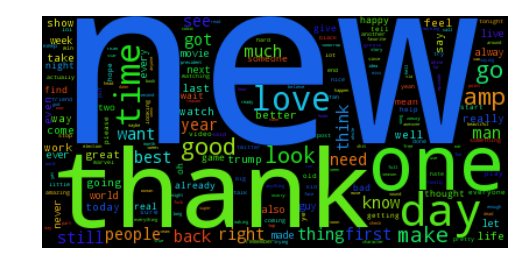

In [90]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def draw_tag_cloud(users_tokens):
    """Draws tag cloud of found tokens"""
    text = ''
    for i in users_tokens:
        for j in i.keys():
            if not j is None:
                text = text + j + " "

    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    return

draw_tag_cloud(users_tokens)